# Section Goals

- Understand a variety of object detection methods
- We will slowly build up to more complex methods as we go along.

# Section Summary

- Template Matching
> Simply looking for an exact copy of an image in another image
    
- Corner Detection
> Looking for corners in images

- Edge Detection
> Expanding to find general edges of objects

- Grid Detection
> Combining both concepts to find grids in images (useful for appications)

- Contour Detection
> - Allows us to detect foreground vs background images.
> - Also allows for detection of external vs internal contours (e.g. grabbing the eyes and smile from a cartoon smile face).

- Feature Matching 
> More advanced methods of detedting matching objects in another image, even if the target image is not shown exactly the same in the image we are searching.

- Watershed Algorithm
> - Advanced algorithm that allows us to segment images into foreground and background.
> - Also allows us to manually set seeds to choose segments of an image.

- Facial and Eye Detection
> - We'll use Haar Cascades to detect faces in images.
> - Note, this is not yet facial **recognition**, that requires deep learning which we learn in future section.

- At the end, We'll build a full computer vision application that can blur licence plates automatically.
*****

# 1. Template Matching

- Template matching is the simplest form of object detection
- It simply scans a larger image for a provided template by sliding the template target image across the larger image.
- The main option that can be adjusted is the comparison method used as the target tamplate is slid across the larger image.
- The methods are all some sort of correlation based metrics.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

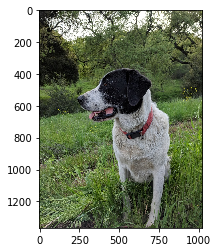

In [2]:
full = cv2.imread('data/sammy.jpg')
full = cv2.cvtColor(full, cv2.COLOR_BGR2RGB)
plt.imshow(full)

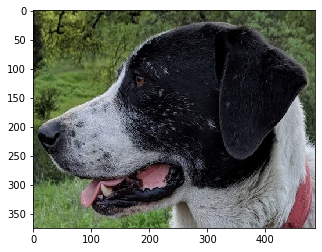

In [3]:
face = cv2.imread('data/sammy_face.jpg')
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
plt.imshow(face)

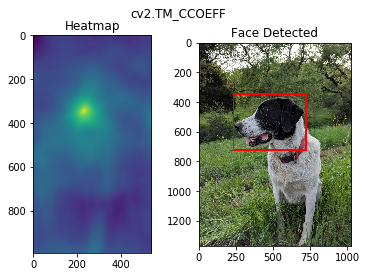

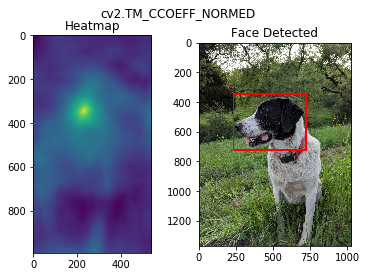

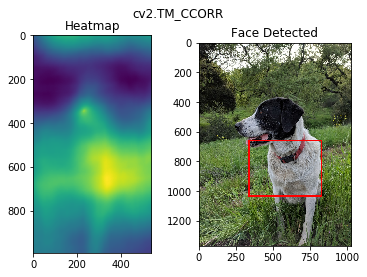

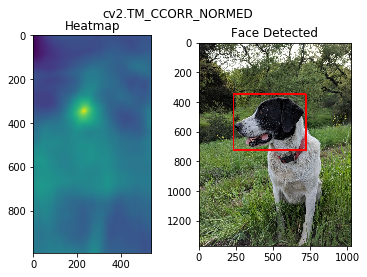

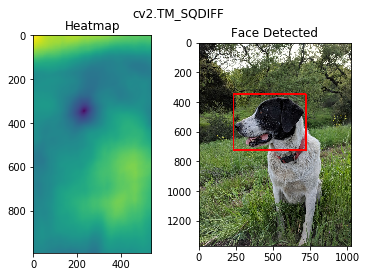

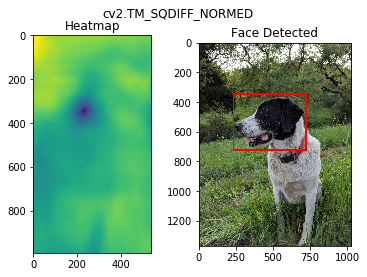

In [7]:
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 
           'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for m in methods:
    
    full_copy = full.copy()
    method = eval(m)
    res = cv2.matchTemplate(full_copy, face, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
        
    height, width, channels = face.shape
    bottom_right = (top_left[0] + width, top_left[1] + height)
    
    cv2.rectangle(full_copy, top_left, bottom_right, (255, 0, 0), 10)
    plt.subplot(121)
    plt.imshow(res)
    plt.title('Heatmap TM')
    
    plt.subplot(122)
    plt.imshow(full_copy)
    plt.title('Face Detected')
    
    plt.suptitle(m)
    plt.show()

# Corner Detection

- When thincking about corner detection in computer vision, we should ask oueselves: What is a corner?
- A corner is a point whose local neighborhood stands in two dominant and different edge directions.
- A corner can be interpreted as the junction of two edges, where an edge is a sudden change in image brightness.
- There are various corner detection algorithms.
- We will ake a look at some of the most popular algorithms:
> - Harris Corner Detection
> - Shi-Tomasi Corner Detection

- Harris Corner Detection
> - The basics intuition is that corners can be detectd by looking for significant chage in all directions.

- Shi-Tomasi Corner Detection
> - It made a small modification to the Harris Corner Detector which ended up with better results.

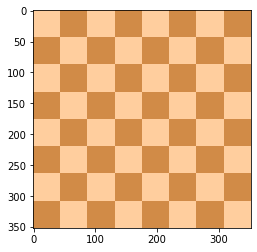

In [9]:
flat_chess = cv2.imread('data/flat_chessboard.png')
flat_chess = cv2.cvtColor(flat_chess, cv2.COLOR_BGR2RGB)

plt.imshow(flat_chess)

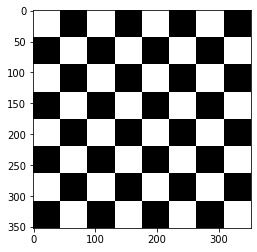

In [10]:
gray_flat_chess = cv2.imread('data/flat_chessboard.png', 0)
plt.imshow(gray_flat_chess, cmap='gray')

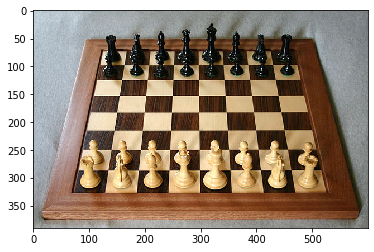

In [11]:
real_chess = cv2.imread('data/real_chessboard.jpg')
real_chess = cv2.cvtColor(real_chess, cv2.COLOR_BGR2RGB)

plt.imshow(real_chess)

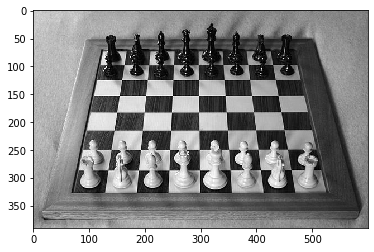

In [12]:
gray_real_chess = cv2.imread('data/real_chessboard.jpg', 0)
plt.imshow(gray_real_chess, cmap='gray')

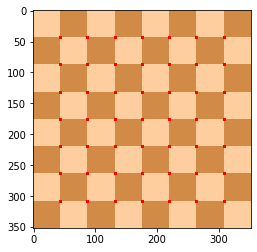

In [13]:
gray = np.float32(gray_flat_chess)

dst = cv2.cornerHarris(src=gray, blockSize=2, ksize=3, k=0.04)
dst = cv2.dilate(dst, None)

flat_chess[dst > 0.01 * dst.max()] = [255, 0, 0]

plt.imshow(flat_chess)

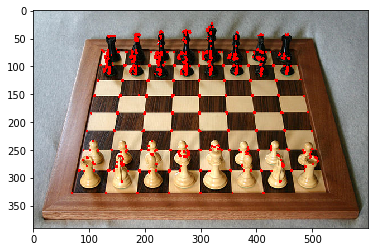

In [14]:
gray = np.float32(gray_real_chess)

dst = cv2.cornerHarris(src=gray, blockSize=2, ksize=3, k=0.04)
dst = cv2.dilate(dst, None)

real_chess[dst > 0.01 * dst.max()] = [255, 0, 0]

plt.imshow(real_chess)

In [28]:
flat_chess = cv2.imread('data/flat_chessboard.png')
flat_chess = cv2.cvtColor(flat_chess, cv2.COLOR_BGR2RGB)

gray_flat_chess = cv2.imread('data/flat_chessboard.png', 0)

real_chess = cv2.imread('data/real_chessboard.jpg')
real_chess = cv2.cvtColor(real_chess, cv2.COLOR_BGR2RGB)

gray_real_chess = cv2.imread('data/real_chessboard.jpg', 0)

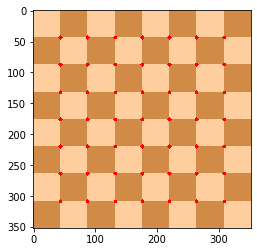

In [29]:
corners = cv2.goodFeaturesToTrack(gray_flat_chess, 64, 0.01, 10)
corners = np.int0(corners)

for i in corners:
    x, y = i.ravel()
    cv2.circle(flat_chess, (x, y), 3, (255, 0, 0), -1)
    
plt.imshow(flat_chess)

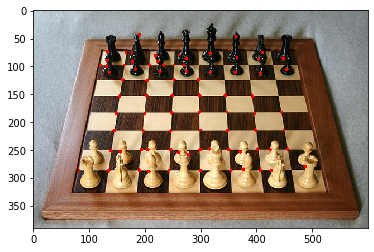

In [30]:
corners = cv2.goodFeaturesToTrack(gray_real_chess, 80, 0.01, 10)
corners = np.int0(corners)

for i in corners:
    x, y = i.ravel()
    cv2.circle(real_chess, (x, y), 3, (255, 0, 0), -1)
    
plt.imshow(real_chess)

# Edge Detection

- In this part we will learn how to use the Canny edge setector, one of the most popular edge detection algorithms.
- Canny Edge Detection Process
> - Apply Gaussian filter to smooth the image in order to remove the noise
> - Find the intensity gradients of the image
> - Apply non-maximum suppression to get rid of spurious response to edge detection
> - Apply double threshold to determine potential edges
> - Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

- For high resolution images where you only want general edges, it is usually a good idea to apply a custom blur before applying the Canny Algorithm

- The Canny Algorithm also requires a user to decide on low and high threshold values.
- We are going o provide an equation for picking a good starting point for threshold values, but often you will need to adjust to your particular image.

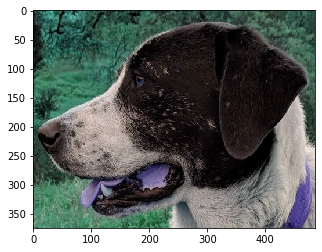

In [33]:
img = cv2.imread('data/sammy_face.jpg')
plt.imshow(img)

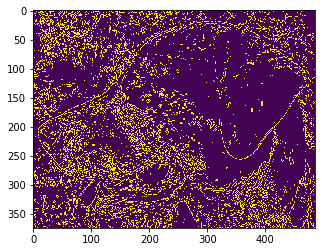

In [34]:
edges = cv2.Canny(image=img, threshold1=127, threshold2=127)
plt.imshow(edges)

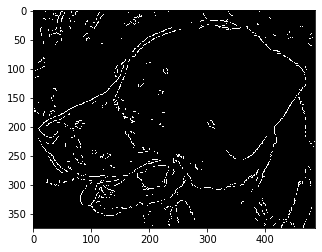

In [38]:
med_val = np.median(img)

# LOWER THRESHOLD TO EITHER 0 OR 70% OF THE MEDIAN VALUE WHICHEVER IS GREATER
lower = int(max(0, 0.7 * med_val))

# UPPER THRESHOLD TO EITHER 130% OF THE MEDIAN OR THE MAX 255, WHICH IS SMALLER
upper = int(min(255, 1.3 * med_val))

blurred_img = cv2.blur(img, ksize=(7, 7))

edges = cv2.Canny(image=blurred_img, threshold1=upper, threshold2=lower + 50)
plt.imshow(edges, cmap='gray')

# Grid Detection

- Often Cameras can create a distortion in an image, such as radial distortion and tangential distortion.
- A good way to account for these distortions when performing operations like object tracking is to have a recognizable pattern attached to the object being tracked.
- Grid patterns are often use to calibrate cameras and track motion.

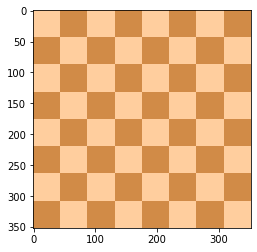

In [39]:
flat_chess = cv2.imread('data/flat_chessboard.png')
flat_chess = cv2.cvtColor(flat_chess, cv2.COLOR_BGR2RGB)

plt.imshow(flat_chess)

In [40]:
found, corners = cv2.findChessboardCorners(flat_chess, (7, 7))

print(found)


True


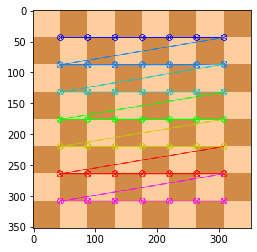

In [41]:
plt.imshow(cv2.drawChessboardCorners(flat_chess, (7, 7), corners, found))

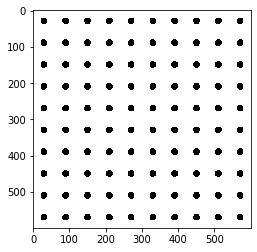

In [44]:
dots = cv2.imread('data/dot_grid.png')
plt.imshow(dots)

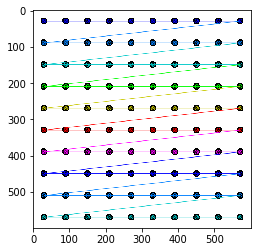

In [49]:
found, corners = cv2.findCirclesGrid(dots, (10, 10), cv2.CALIB_CB_SYMMETRIC_GRID)
cv2.drawChessboardCorners(dots, (10, 10), corners, found)
plt.imshow(dots)

# Contour Detection

- Contours are defined as simply a curve joining all the continuous points (along the boundary), having same color or intensity.
- Contours are useful tool for shape analysis and object detection and recognition.
- OpenCV has a built in Counter finder function that can also helps us differentiate between internal and extrnal contours.

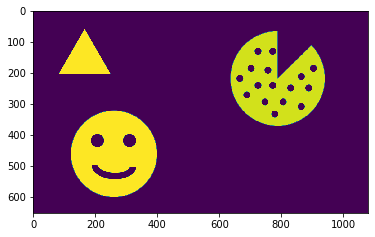

In [52]:
img = cv2.imread('data/internal_external.png', 0)
plt.imshow(img)

In [67]:
contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

print(type(contours))
print(len(contours))

<class 'list'>
22


In [68]:
len(cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE))

2

In [69]:
external_contours = np.zeros(img.shape)

In [70]:
for i in range(len(contours)):
    
    # External contour
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(external_contours, contours, i, 255, -1)

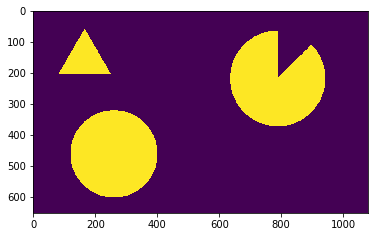

In [71]:
plt.imshow(external_contours)

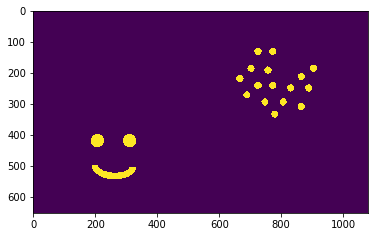

In [72]:
internal_contours = np.zeros(img.shape)

for i in range(len(contours)):
    
    # External contour
    if hierarchy[0][i][3] != -1:
        cv2.drawContours(internal_contours, contours, i, 255, -1)
        
plt.imshow(internal_contours)

# Feature Matching

- Feature matching extracts defining key features from an input image (using ideas from corner, edge, and contour detection).
- The using a distance calculation, finds all the matches in a secondary image.
- This means we are